In [500]:
# Lets import necessary libraries.
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [501]:
df=pd.read_csv('../data/stroke.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [502]:
# Checking how many null values there are in the dataset 
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [503]:
# Clean data
# Drop rows with missing values (or use imputation)
df.dropna(inplace=True)


In [505]:
# Encode categorical variables
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)

# Separate features and target
X = df.drop(columns=['stroke', 'id'])
y = df['stroke']



In [506]:
# Exploratory Data Analysis



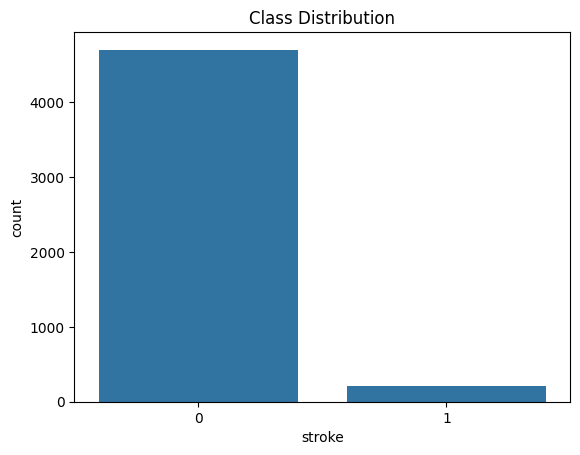

In [507]:
# Class balance
sns.countplot(x='stroke', data=df)
plt.title("Class Distribution")
plt.show()


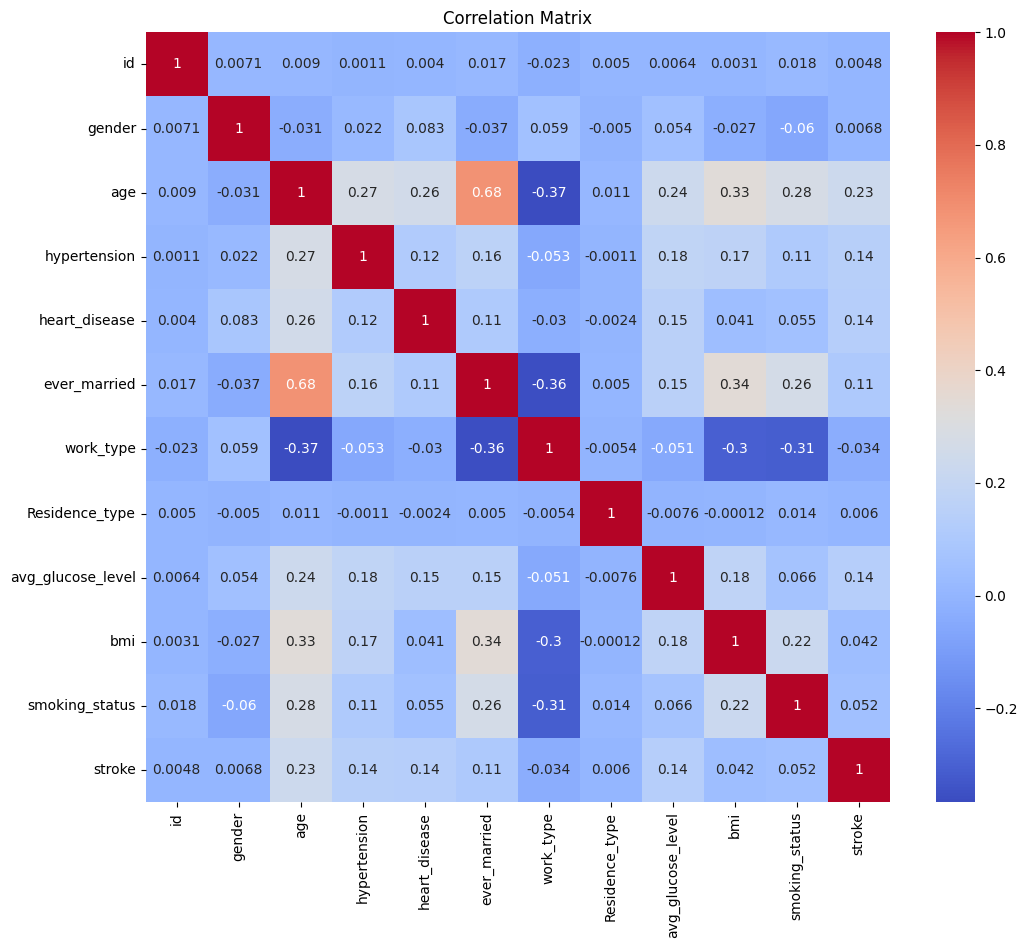

In [508]:
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

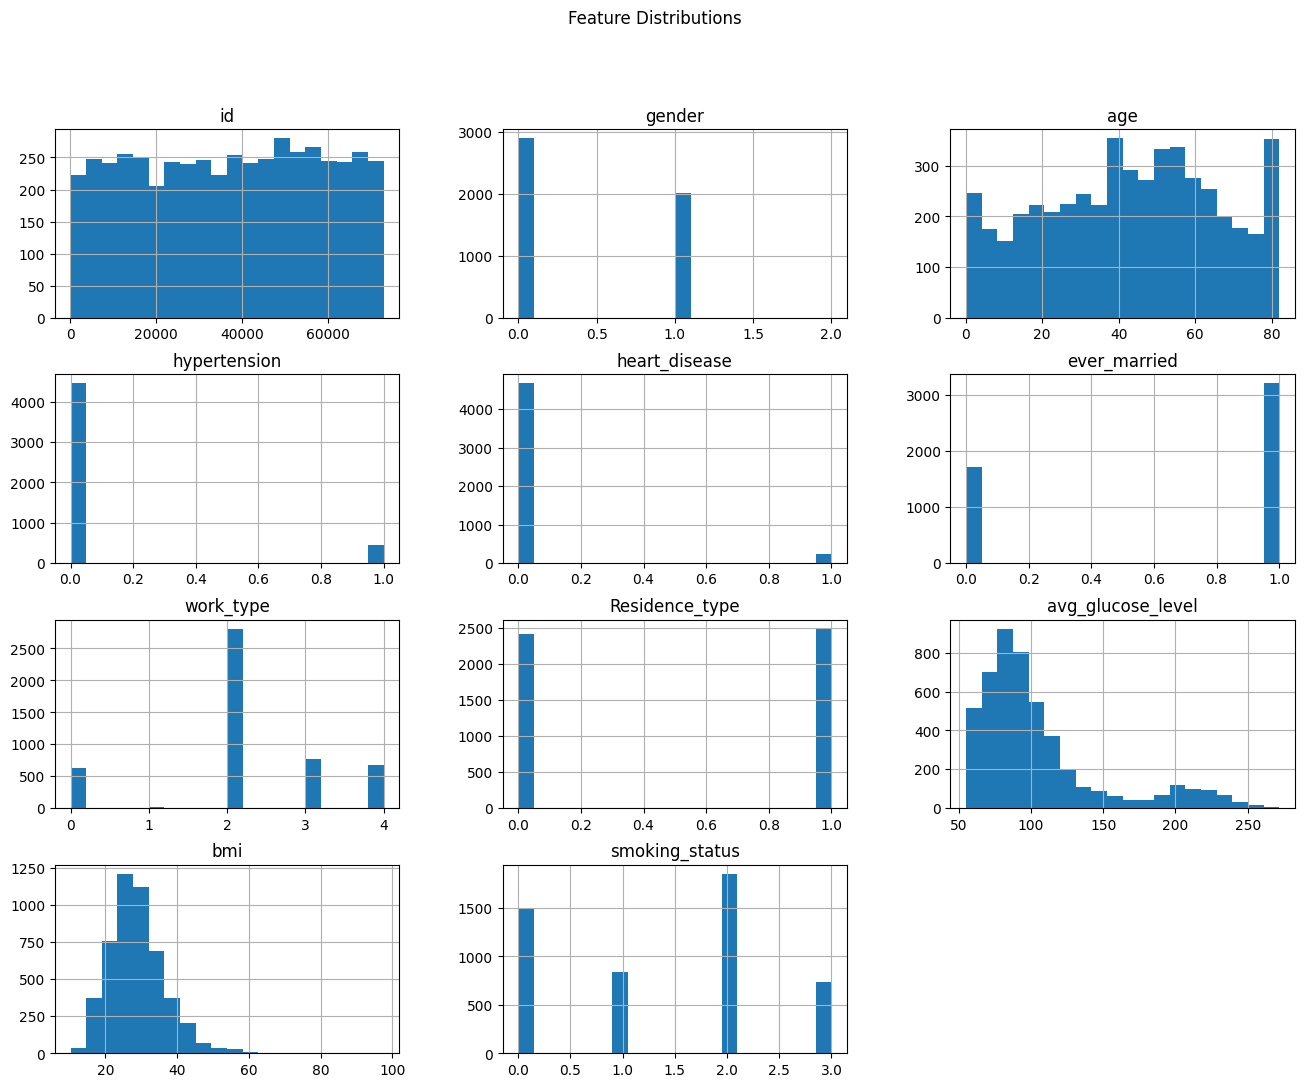

In [509]:
# Histograms
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('stroke')
df[numeric_cols].hist(bins=20, figsize=(16,12))
plt.suptitle("Feature Distributions")
plt.show()

In [510]:
#Split Data & Scale

In [511]:
# 1. Separate features and target
X_columns = df.columns.drop('stroke')
X = df[X_columns]
y = df['stroke']

# 2. Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. First split: Train (70%) and Test (30%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# 4. Second split: Train (70%) → Train (80%) and Validation (20%) from that
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

# 5. Apply SMOTE to balance training set
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# 6. Print dataset shapes for confirmation
print(f"Train shape: {X_train_res.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (5262, 11)
Validation shape: (688, 11)
Test shape: (1473, 11)


In [512]:
# Train Models

In [513]:
models = {
   "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "k-NN": KNeighborsClassifier(n_neighbors=5) 
}
# Store results
results = []

for name, model in models.items():
    print(f"\n=== {name} ===")
    
    # Start time
    start = time.time()
    
    # Train the model
    model.fit(X_train_res, y_train_res)  # Using SMOTE-resampled training data
    
    # End time
    duration = time.time() - start
    
    # Predict on test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    
    # ROC AUC
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    # Classification report
    print("Accuracy:", acc)
    print("Training Time: {:.2f}s".format(duration))
    print(classification_report(y_test, y_pred))
    if auc:
        print("ROC AUC:", auc)

        # Append to results table
    results.append({
        'Model': name,
        'Accuracy': acc,
        'ROC AUC': auc,
        'Train Time (s)': round(duration, 2)
    })

# Final comparison table
results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
print(results_df.sort_values(by='ROC AUC', ascending=False))


=== Logistic Regression ===
Accuracy: 0.7630685675492193
Training Time: 0.02s
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      1410
           1       0.12      0.70      0.20        63

    accuracy                           0.76      1473
   macro avg       0.55      0.73      0.53      1473
weighted avg       0.95      0.76      0.83      1473

ROC AUC: 0.8223685691770797

=== Random Forest ===
Accuracy: 0.9375424304141209
Training Time: 1.29s
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1410
           1       0.03      0.02      0.02        63

    accuracy                           0.94      1473
   macro avg       0.49      0.50      0.49      1473
weighted avg       0.92      0.94      0.93      1473

ROC AUC: 0.7956152200833051

=== Gradient Boosting ===
Accuracy: 0.9144602851323829
Training Time: 1.83s
              precision    recall  f1-score   support

      

In [514]:
# ROC Curves

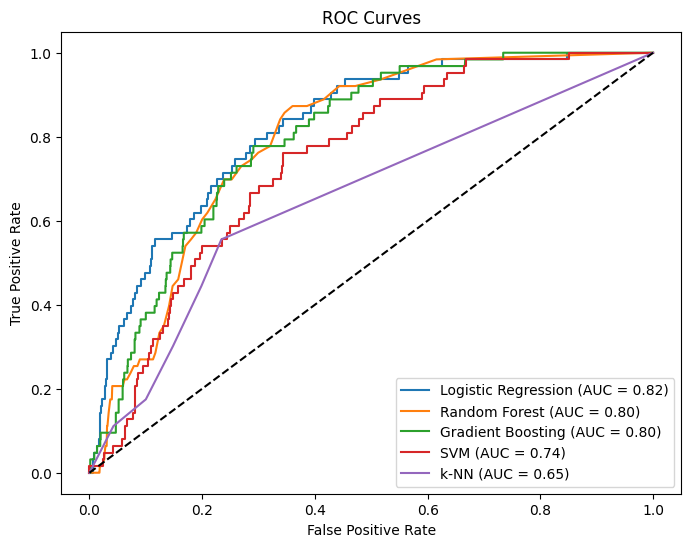

In [515]:
plt.figure(figsize=(8,6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


In [516]:
#Confusion Matrices

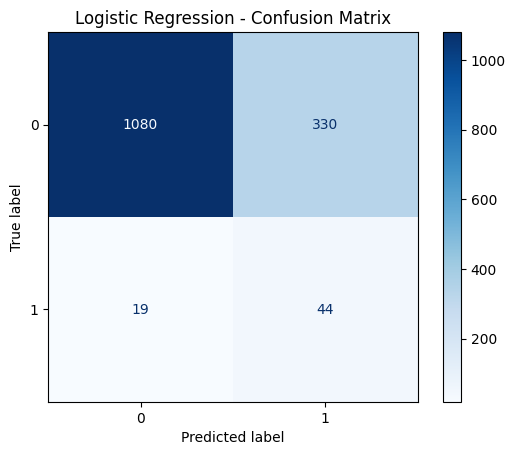

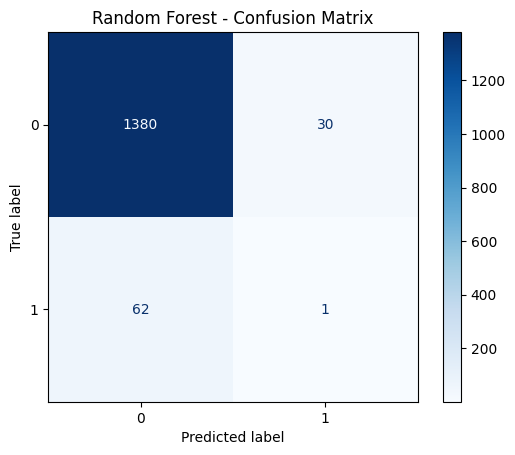

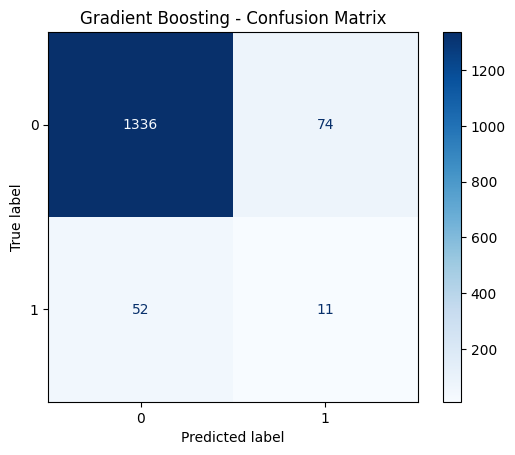

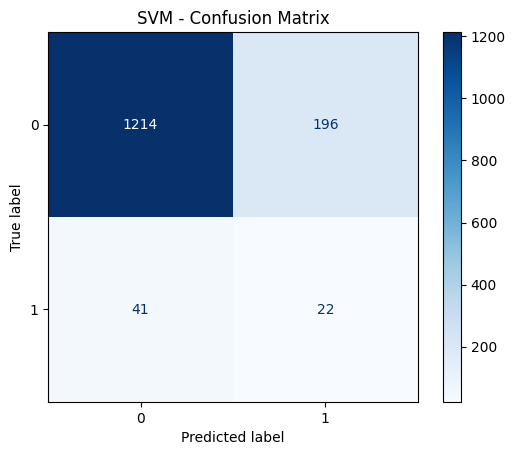

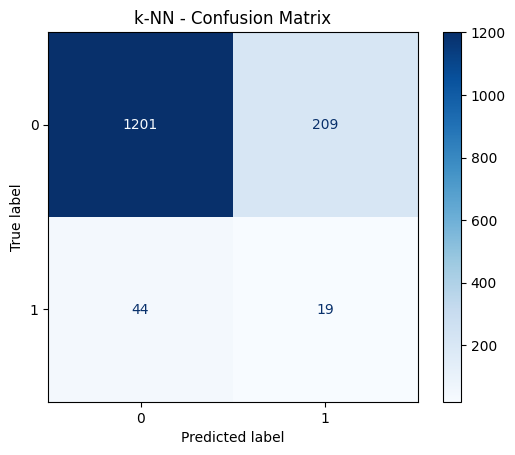

In [517]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()


In [518]:
# Random Forest Feature Importance

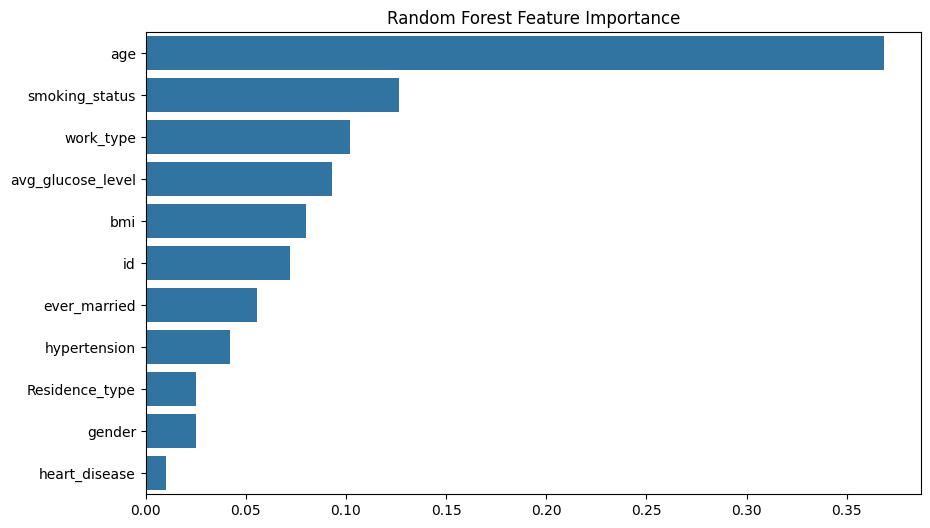

In [519]:
rf = models["Random Forest"]
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=np.array(X_columns)[indices])
plt.title("Random Forest Feature Importance")
plt.show()


In [520]:
# Permutation Feature Importance

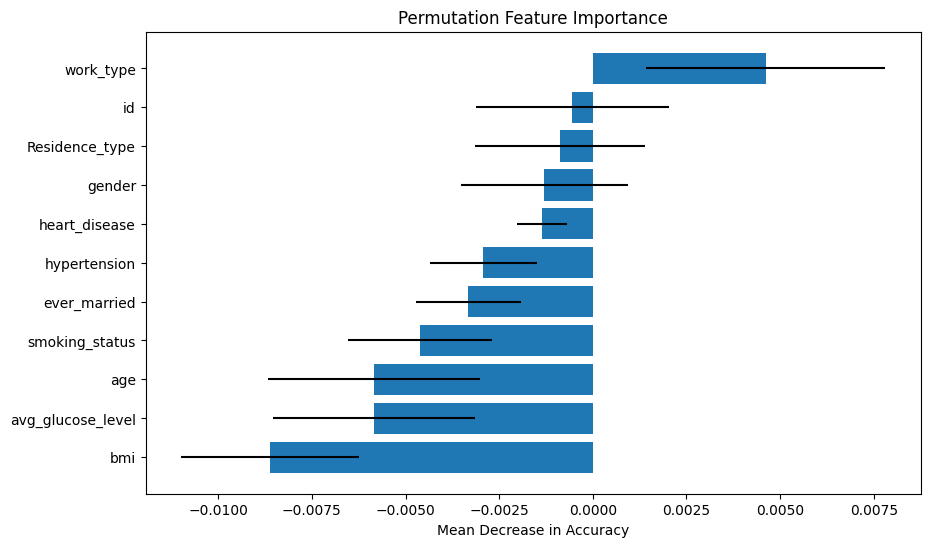

In [521]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10,6))
plt.barh(
    np.array(X_columns)[sorted_idx],
    result.importances_mean[sorted_idx],
    xerr=result.importances_std[sorted_idx]
)
plt.title("Permutation Feature Importance")
plt.xlabel("Mean Decrease in Accuracy")
plt.show()


In [522]:
#Partial Dependence Plots